In [221]:
import os,sys
import cv2
import math
import numpy as np
import itertools
import torch
import torch.nn.functional as F
from PIL import Image
sys.path.append('../')
sys.path.append('../../crnn.pytorch/')
from ctpn import config
from ctpn.ctpn import CTPN_Model
from ctpn.utils import gen_anchor, transform_bbox, clip_bbox, filter_bbox, nms, TextProposalConnectorOriented
import crnn
from config import cfg
import matplotlib.pyplot as plt

In [237]:
def get_text_boxes(image, display = True, prob_thresh = 0.5):
    h, w = image.shape[:2]
    rescale_fac = max(h, w) / 1000
    if rescale_fac > 1.0:
        h = int(h / rescale_fac)
        w = int(w / rescale_fac)
        image = cv2.resize(image, (w,h))
        h, w = image.shape[:2]
    image_c = image.copy()
    image = image.astype(np.float32) - config.IMAGE_MEAN
    image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

    with torch.no_grad():
        cls, regr = model_ctpn(image)
        cls_prob = F.softmax(cls, dim=-1).cpu().numpy()
        regr = regr.cpu().numpy()
        anchor = gen_anchor((int(h / 16), int(w / 16)), 16)
        bbox = transform_bbox(anchor, regr)
        bbox = clip_bbox(bbox, [h, w])

        fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
        select_anchor = bbox[fg, :]
        select_score = cls_prob[0, fg, 1]
        select_anchor = select_anchor.astype(np.int32)
        keep_index = filter_bbox(select_anchor, 16)

        select_anchor = select_anchor[keep_index]
        select_score = select_score[keep_index]
        select_score = np.reshape(select_score, (select_score.shape[0], 1))
        nmsbox = np.hstack((select_anchor, select_score))
        keep = nms(nmsbox, 0.3)
        select_anchor = select_anchor[keep]
        select_score = select_score[keep]

        textConn = TextProposalConnectorOriented()
        text = textConn.get_text_lines(select_anchor, select_score, [h, w])
        if display:
            for i in text:
                s = str(round(i[-1] * 100, 2)) + '%'
                i = [int(j) for j in i]
                cv2.line(image_c, (i[0], i[1]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[0], i[1]), (i[4], i[5]), (0, 0, 255), 2)
                cv2.line(image_c, (i[6], i[7]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[4], i[5]), (i[6], i[7]), (0, 0, 255), 2)
                #cv2.putText(image_c, s, (i[0]+13, i[1]+13), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

        return text, image_c, rescale_fac
    
def load_image(image):
    h, w = image.shape[:2]
    if h != 32 and h < w:
        new_w = int(w * 32 / h)
        image = cv2.resize(image, (new_w, 32))
    if w != 32 and w < h:
        new_h = int(h * 32 / w)
        image = cv2.resize(image, (32, new_h))

    image = Image.fromarray(image).convert('L')
    # cv2.imwrite(image_path, np.array(image))
    image = np.array(image)
    if h < w:
        image = np.array(image).T  # [W,H]
    image = image.astype(np.float32) / 255.
    image -= 0.5
    image /= 0.5
    image = image[np.newaxis, np.newaxis, :, :]  # [B,C,W,H]
    return image

def get_minAreaRect(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    return cv2.minAreaRect(coords)

def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = h
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def rotate_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [91]:
device = torch.device('cpu')
weights_ctpn = '/notebook/ctpn.pytorch/weights/ctpn.pth'
model_ctpn = CTPN_Model().to(device)
model_ctpn.load_state_dict(torch.load(weights_ctpn, map_location=device)['model_state_dict'])
model_ctpn.eval()

CTPN_Model(
  (base_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [94]:
weights_crnn = '/notebook/crnn.pytorch/models/crnn.horizontal.061.pth'
alpha = cfg.word.get_all_words()
model_crnn = crnn.CRNN(num_classes=len(alpha))
model_crnn.load_state_dict(torch.load(weights_crnn, map_location=device)['model'])
model_crnn.eval()

CRNN(
  (cnn): Sequential(
    (conv_block_1): _ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block_2): _ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block_3_1): _ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (conv_block_3_2): _ConvBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (max_pool_3): MaxPool2d(kernel_size=(2, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (conv_block_4_1): _ConvBlock(
      (conv): Conv2d(256, 512, kernel_

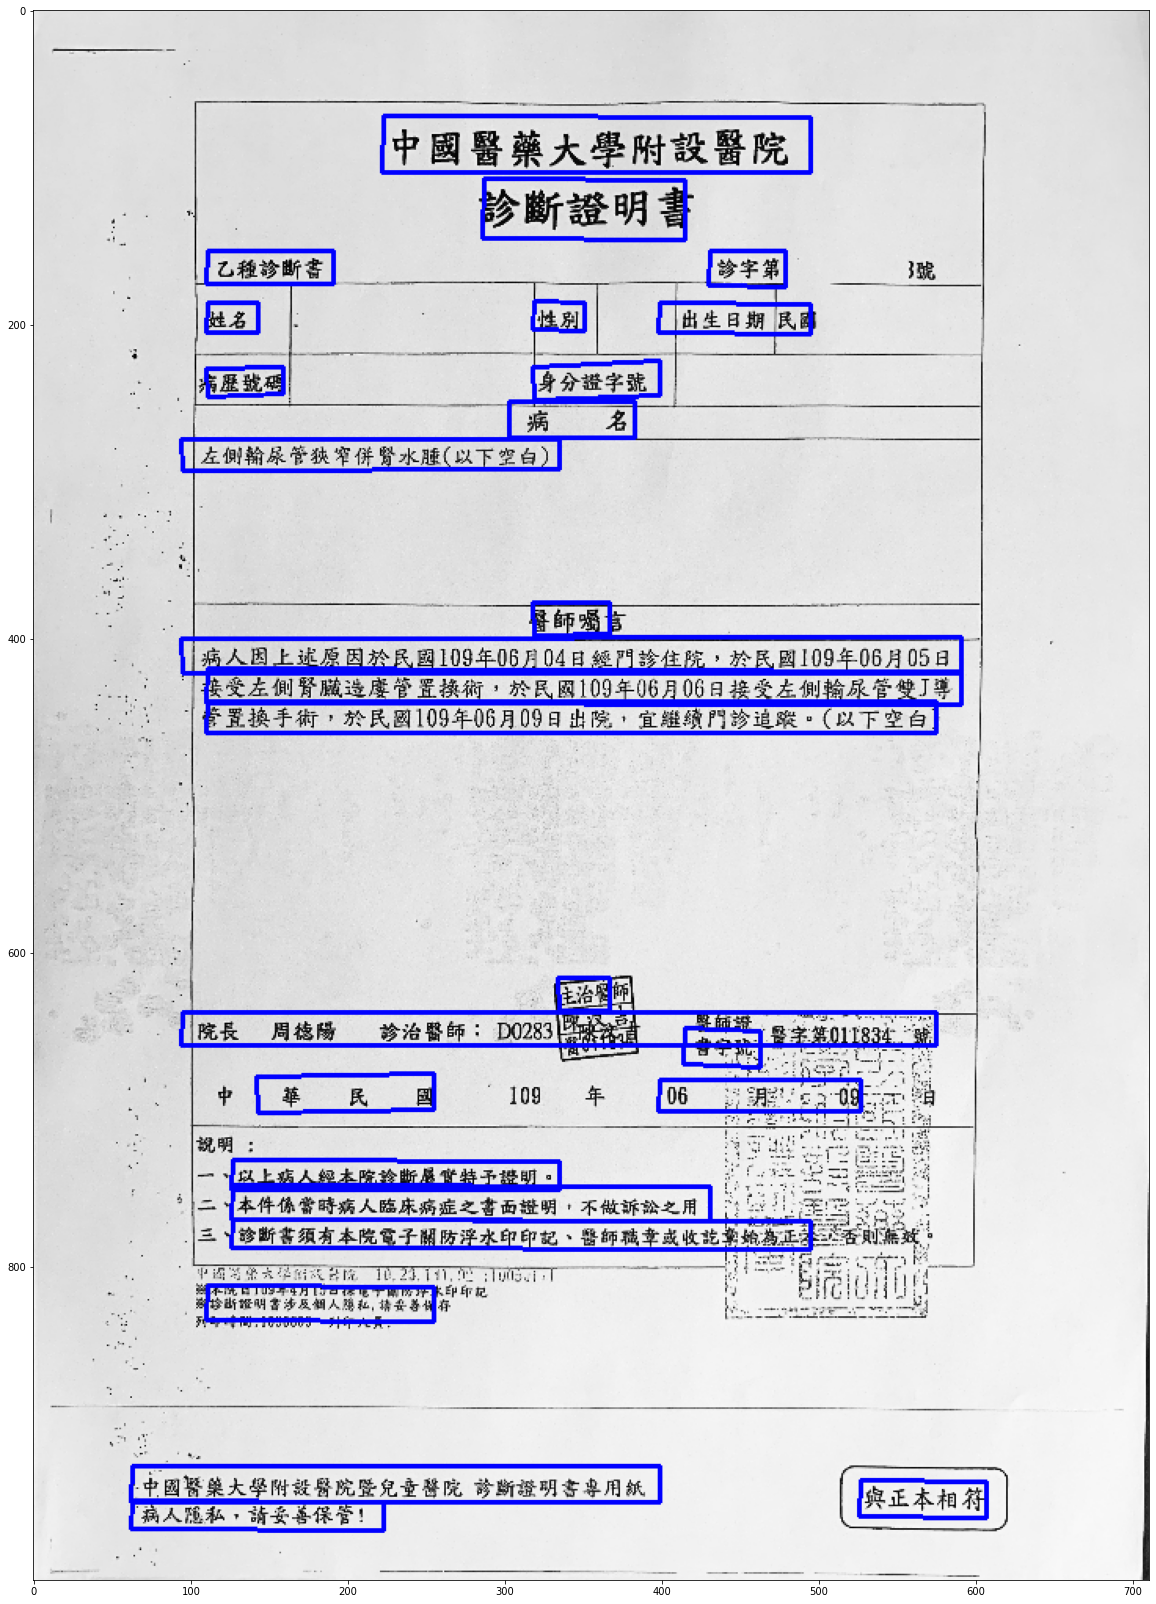

In [254]:
img_path = '/notebook/images/insurance/IMG_5620.jpg'
img = cv2.imread(img_path)
img_rotated = rotate_image(img)
text, out_img, scale = get_text_boxes(img_rotated, prob_thresh=0.1)
plt.figure(figsize=(20,40))
plt.imshow(out_img)

中國醫贛大學附設醫院
＿診字箄
丶以上病人铿本院爹断羼寳特予盥明
嚣師囑
丶本件係凿病人晦床病症之曹面盘明不做新勉之用
接受左側腎臟造廔管置換術﹐於民國㏒年⒃月⒃日接受左側輸尿管雙Ｊ尊
管置換手術﹐於民國⒈年⒃月㏒日出院﹐宜繼續門診追蹤。（以下空白）
與正本相符
ˋ兯國羀藥大學附設醫院暨兒童醫院診斷證明書專用紙
︱姓名
診斷證明書
∣病人因上述原因於民國㏒年⑩月ǖ日經門診住院，於民國Ⅰ㏒年⒗月⒖日
病歷豌碼
︳乙種診断書
性别
ßß༐༐ᡜᡜ࿏ﺋ؛ﺋᡛཽᡮ؛᠐᠅Ж
￣病￣￣召
︱院長周德陽診治嚣師：Ｄ⑿圈粱熟黌瓵證᠁翳宰箫M※⒚粜
∣出生日期民國
丶爹断蕾須有本院蓖子胴防浮水印印記丶嚣師臌章或收能革始蘅蒸
⾄䢔蟨
書学號⿳


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


ᢆ爹斷轝崩᠋赵ᠱ鬮⊿᠍᠌↗婁࿅係
∣身分竳字琥
病人隐私請妥善保管！
︱左側輪尿管狹窄併腎水腫（以下空白）
華民國


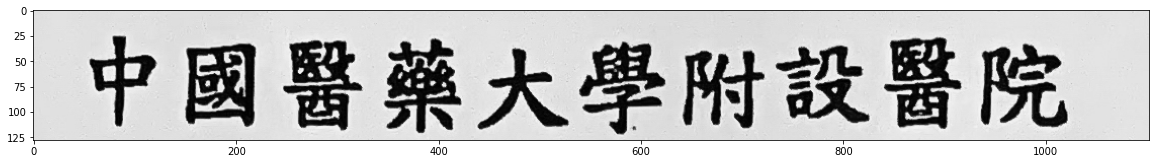

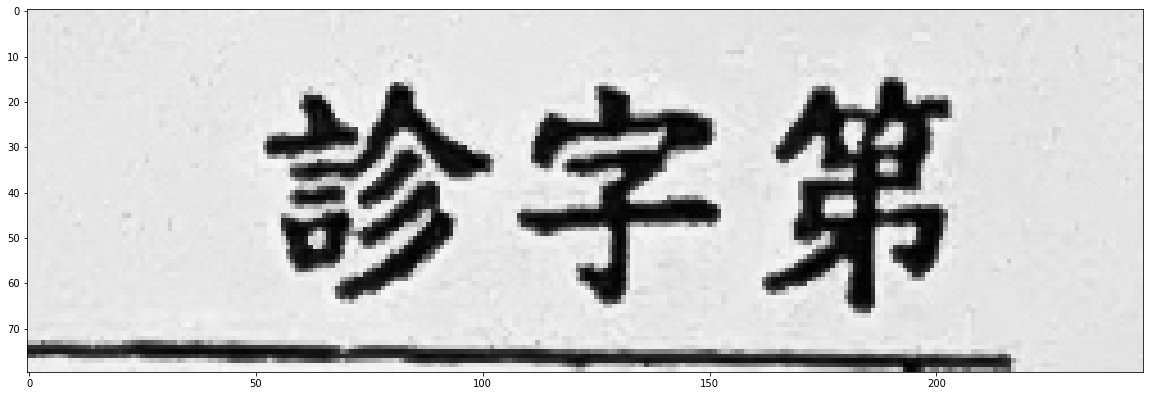

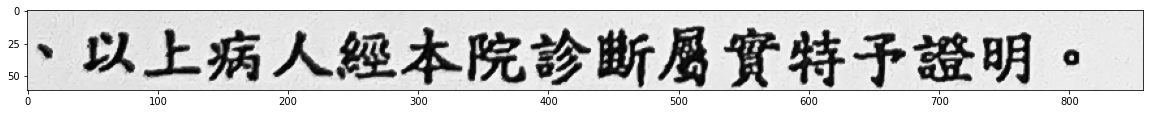

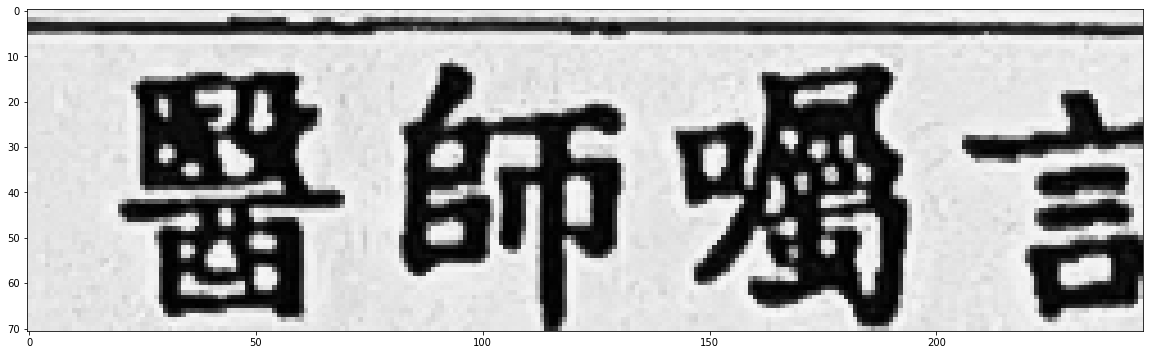

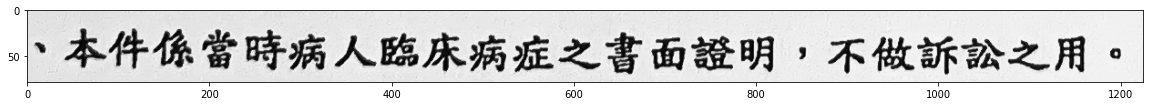

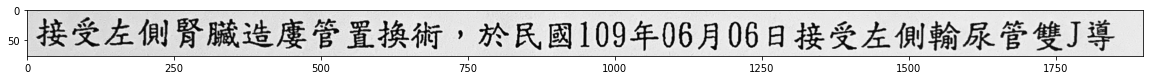

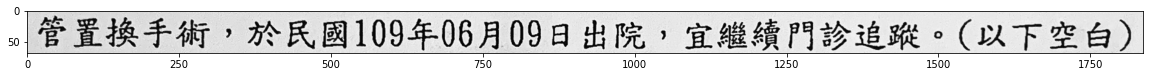

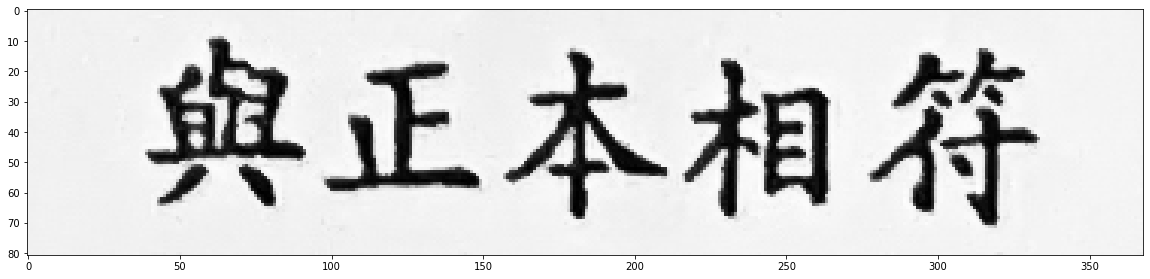

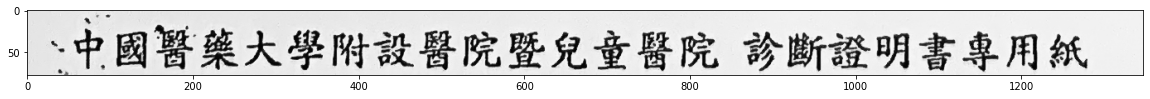

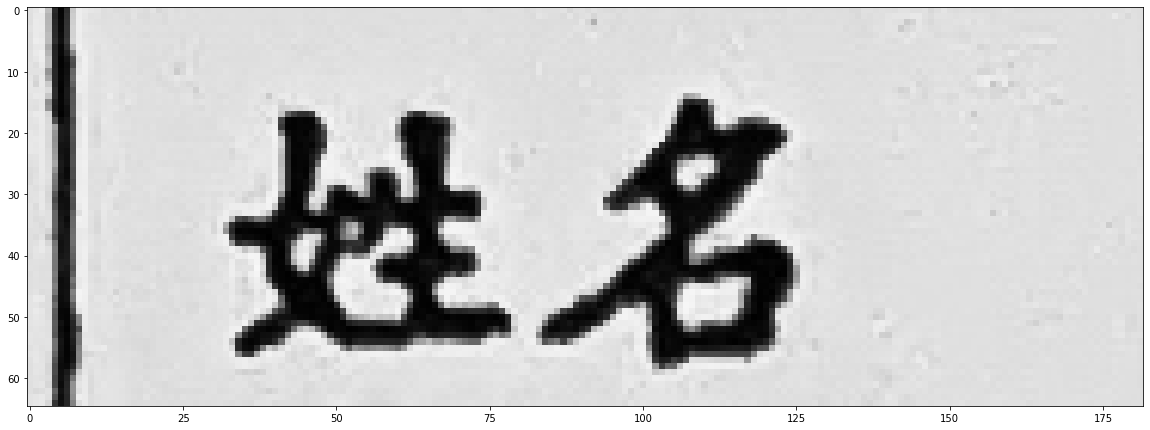

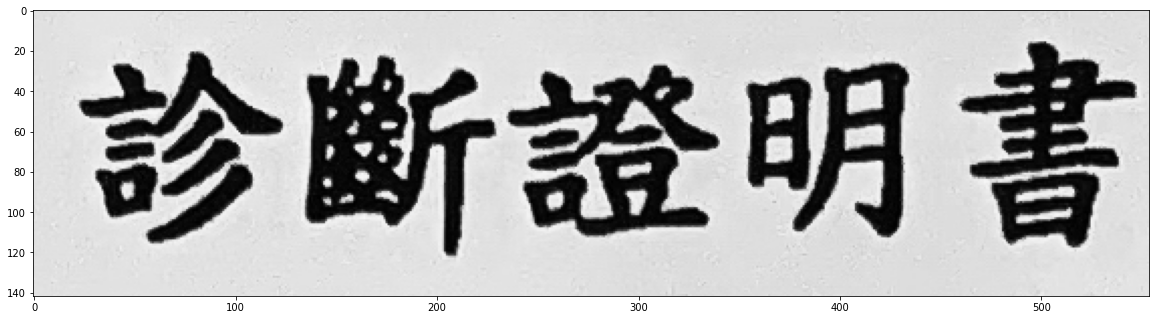

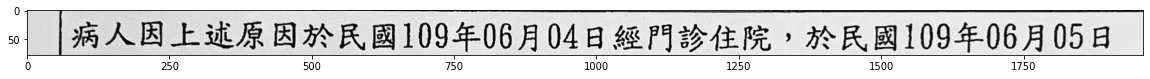

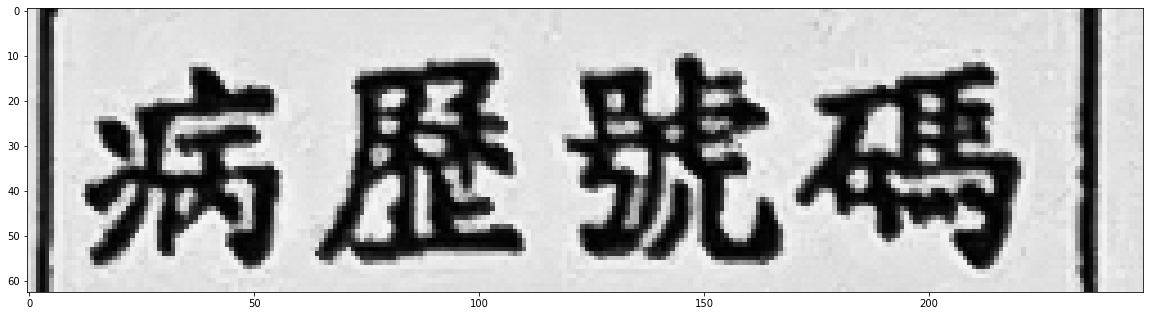

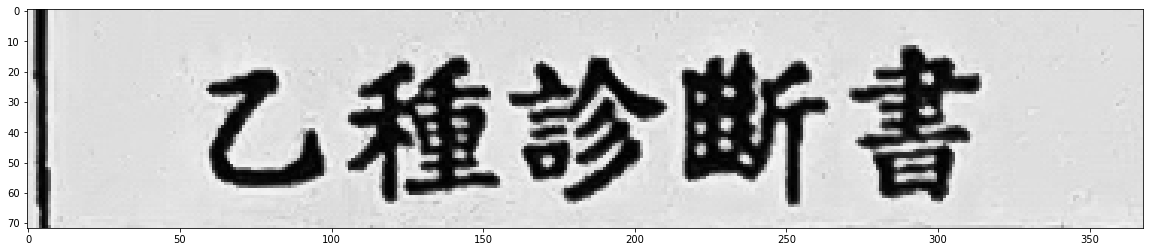

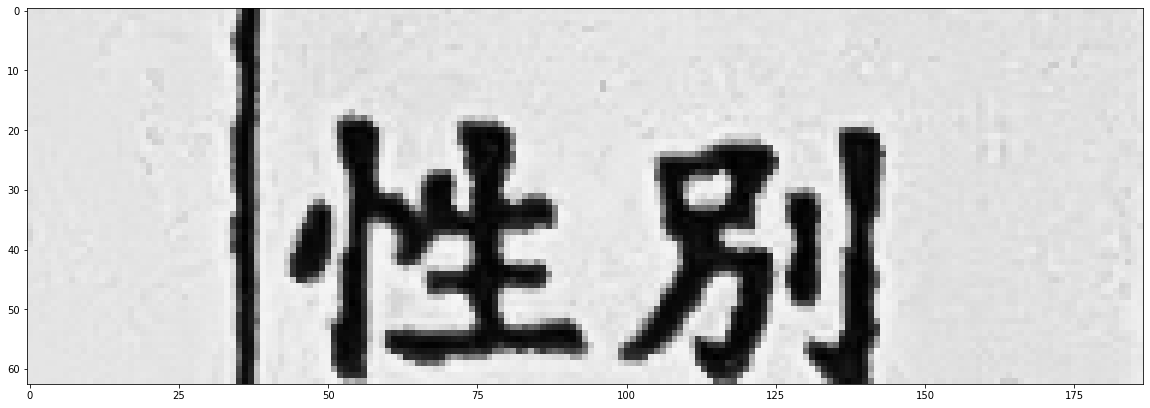

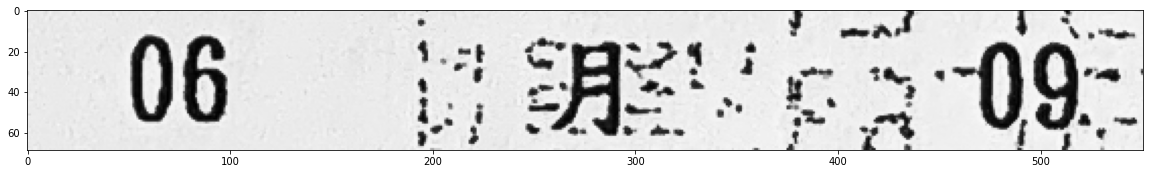

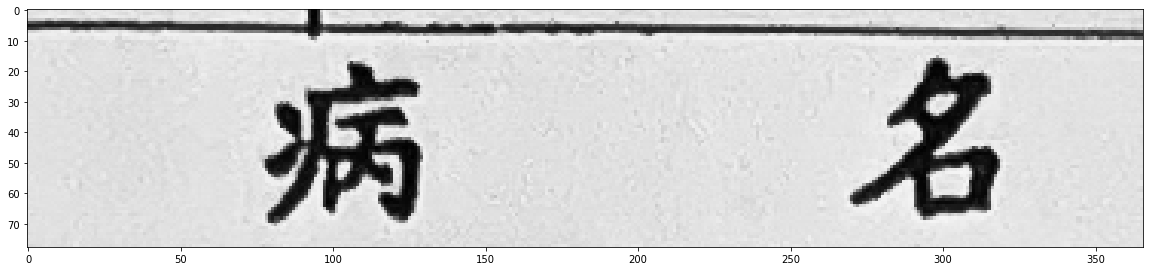

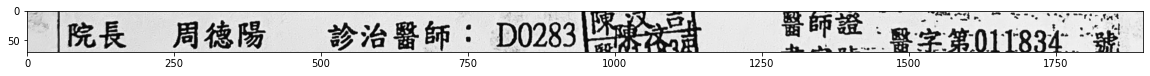

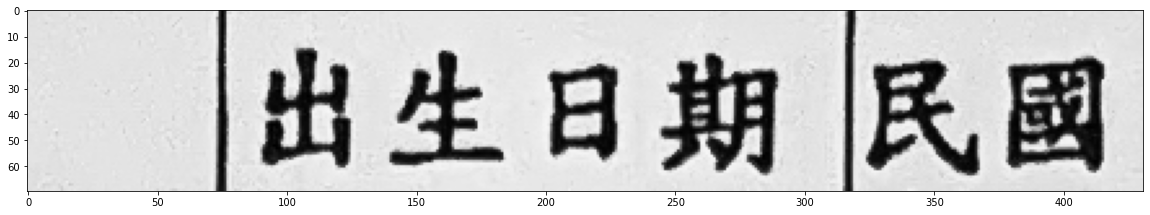

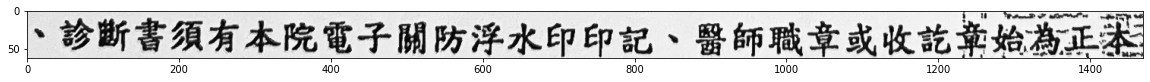

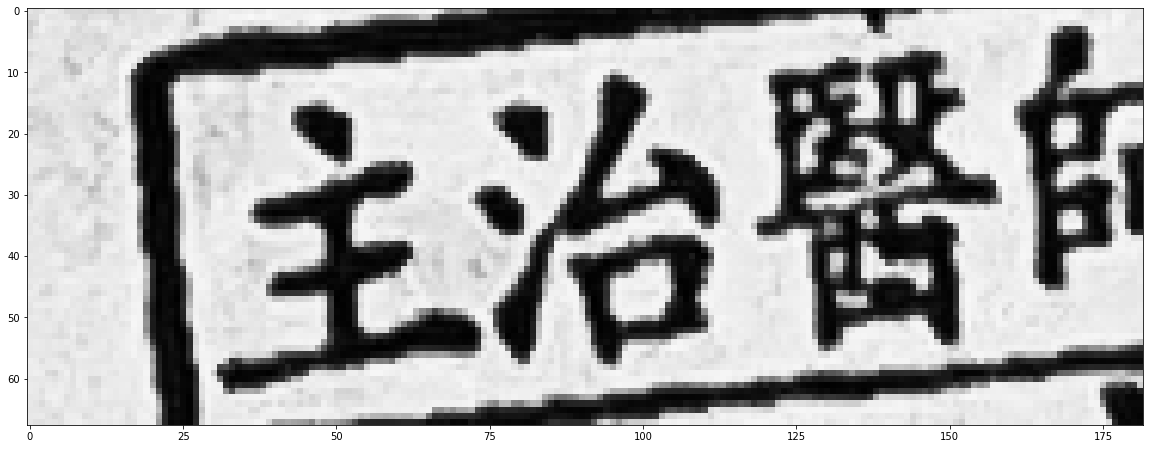

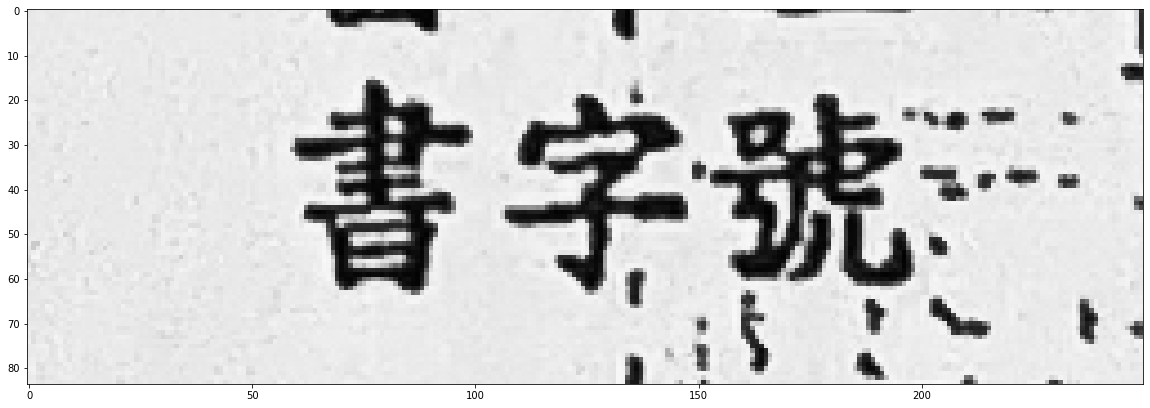

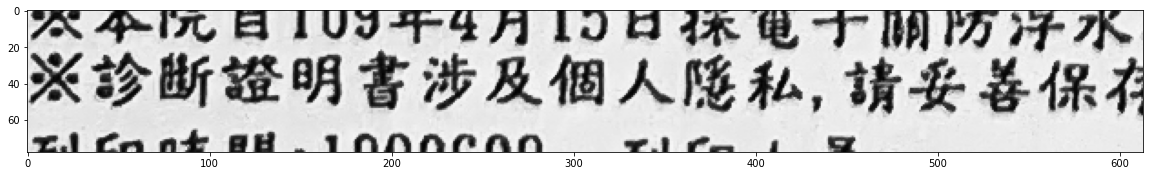

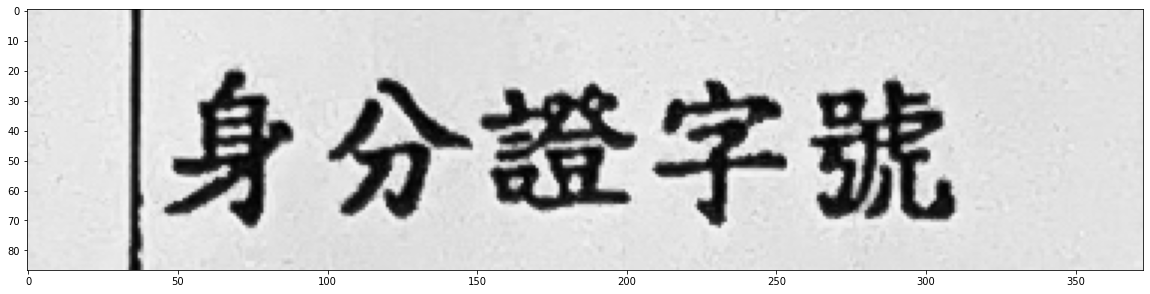

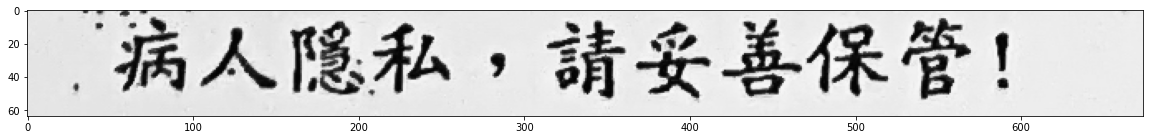

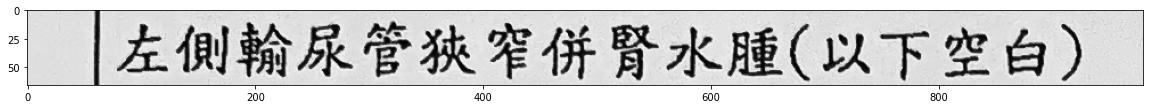

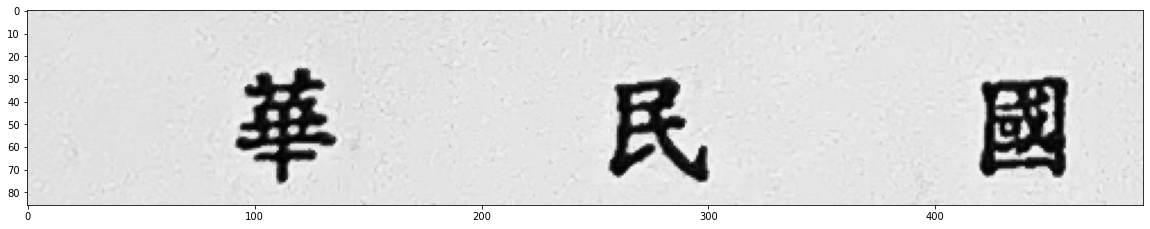

In [255]:
for k in range(text.shape[0]):
    X = text[k][:8][::2]
    Y = text[k][:8][1::2]
    x1, y1 = int(min(X) * scale) - padding, int(min(Y) * scale) + 5
    x2, y2 = int(max(X) * scale) + padding, int(max(Y) * scale) - 5
    img_crop = img[y1:y2, x1:x2]
    img_crnn = load_image(img_crop)
    img_crnn = torch.FloatTensor(img_crnn)
    predict = model_crnn(img_crnn)[0].detach().numpy()
    label = np.argmax(predict[:], axis=1)
    label = [alpha[class_id] for class_id in label]
    label = [k for k, g in itertools.groupby(list(label))]
    label = ''.join(label).replace(' ', '')
    print(label)
    plt.figure(figsize=(20,40))
    plt.imshow(img_crop)